In [ ]:
!pip install rasterio geopandas pyproj catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Проверка и преобразование систем координат

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio

# Загрузка таблицы координат с указанием заголовка
coord = pd.read_excel(
    "/content/drive/MyDrive/gazprom_data/full_table.xlsx",
    sheet_name="Coord",
    header=0  # Заголовки в первой строке
)

# Удаление строки с метками 'X (UTM 36N)' и 'Y (UTM 36N)'
coord = coord.drop(0).reset_index(drop=True)

# Переименование столбцов
coord = coord.rename(columns={
    "Координаты": "X (UTM 36N)",
    "Unnamed: 6": "Y (UTM 36N)"
})

# Преобразование координат в числа (замена запятых на точки)
coord["X (UTM 36N)"] = (
    coord["X (UTM 36N)"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

coord["Y (UTM 36N)"] = (
    coord["Y (UTM 36N)"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Проверка данных
print("Первые строки таблицы после обработки:")
print(coord.head())

# Создание GeoDataFrame
gdf = gpd.GeoDataFrame(
    coord,
    geometry=gpd.points_from_xy(
        coord["X (UTM 36N)"],
        coord["Y (UTM 36N)"]
    ),
    crs="EPSG:32636"  # UTM Zone 36N
)

Первые строки таблицы после обработки:
   №пп  Год пробоотбора № станции (точки) № для карты Unnamed: 4  \
0  1.0           2021.0        WS-2021_1K      WS.01K        01K   
1  2.0           2021.0        WS-2021_2K      WS.02K        02K   
2  3.0           2021.0        WS-2021_3K      WS.03K        03K   
3  4.0           2021.0        WS-2021_4K      WS.04K        04K   
4  5.0           2021.0        WS-2021_5K      WS.05K        05K   

    X (UTM 36N)   Y (UTM 36N)  
0  506118.75890  7.378013e+06  
1  506261.94920  7.378349e+06  
2  506468.88347  7.378803e+06  
3  506608.10000  7.379110e+06  
4  506769.65000  7.379459e+06  


# Извлечение признаков из ГЛБО

In [ ]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops

# Проверка CRS растра
with rasterio.open("/content/drive/MyDrive/gazprom_data/00_SideScanSonar.tif") as src:
    image = src.read(1)
    transform = src.transform
    crs_raster = src.crs

# Преобразование к CRS растра (если необходимо)
if gdf.crs != crs_raster:
    gdf = gdf.to_crs(crs_raster)
    print("\nКоординаты преобразованы к CRS растра:", crs_raster)

# Сохранение для проверки
gdf.to_file("Координаты_в_CRS_растра.geojson", driver="GeoJSON")
# Параметры окрестности
window_size = 50
half_window = window_size // 2

# Создание колонок для признаков
gdf["mean_intensity"] = np.nan
gdf["contrast"] = np.nan

# Извлечение данных для каждой точки
for idx, row in gdf.iterrows():
    x, y = row.geometry.x, row.geometry.y
    # Преобразование координат в индексы пикселей
    px, py = rasterio.transform.rowcol(transform, x, y)

    # Проверка границ изображения
    if (px - half_window >= 0) and (px + half_window < image.shape[0]) and (py - half_window >= 0) and (py + half_window < image.shape[1]):
        patch = image[px - half_window : px + half_window + 1, py - half_window : py + half_window + 1]

        # Средняя интенсивность
        gdf.loc[idx, "mean_intensity"] = np.mean(patch)

        # Текстура (контраст через GLCM)
        glcm = graycomatrix(patch.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        gdf.loc[idx, "contrast"] = graycoprops(glcm, "contrast")[0, 0]
    else:
        print(f"Точка {row['Точка']} ({x}, {y}) выходит за границы изображения.")

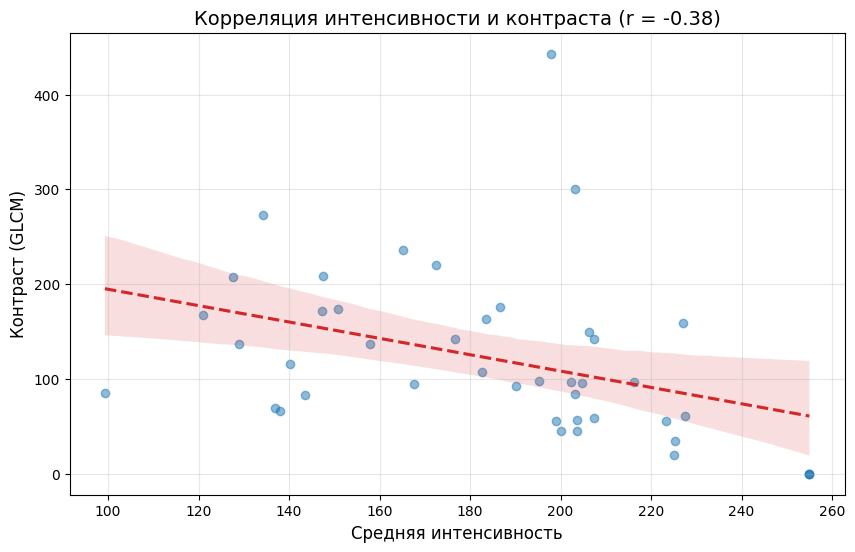

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Фильтрация NaN (точки за границами изображения)
valid_data = gdf.dropna(subset=['mean_intensity', 'contrast'])

# Создание фигуры
plt.figure(figsize=(10, 6))

# Точечный график с линией регрессии
sns.regplot(
    data=valid_data,
    x='mean_intensity',
    y='contrast',
    scatter_kws={'alpha': 0.5, 'color': '#1f77b4'},
    line_kws={'color': '#d62728', 'linestyle': '--'}
)

# Расчёт корреляции
corr = valid_data[['mean_intensity', 'contrast']].corr().iloc[0, 1]

# Аннотация
plt.title(f'Корреляция интенсивности и контраста (r = {corr:.2f})', fontsize=14)
plt.xlabel('Средняя интенсивность', fontsize=12)
plt.ylabel('Контраст (GLCM)', fontsize=12)
plt.grid(alpha=0.3)

# Сохранение
plt.savefig('intensity_vs_contrast_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

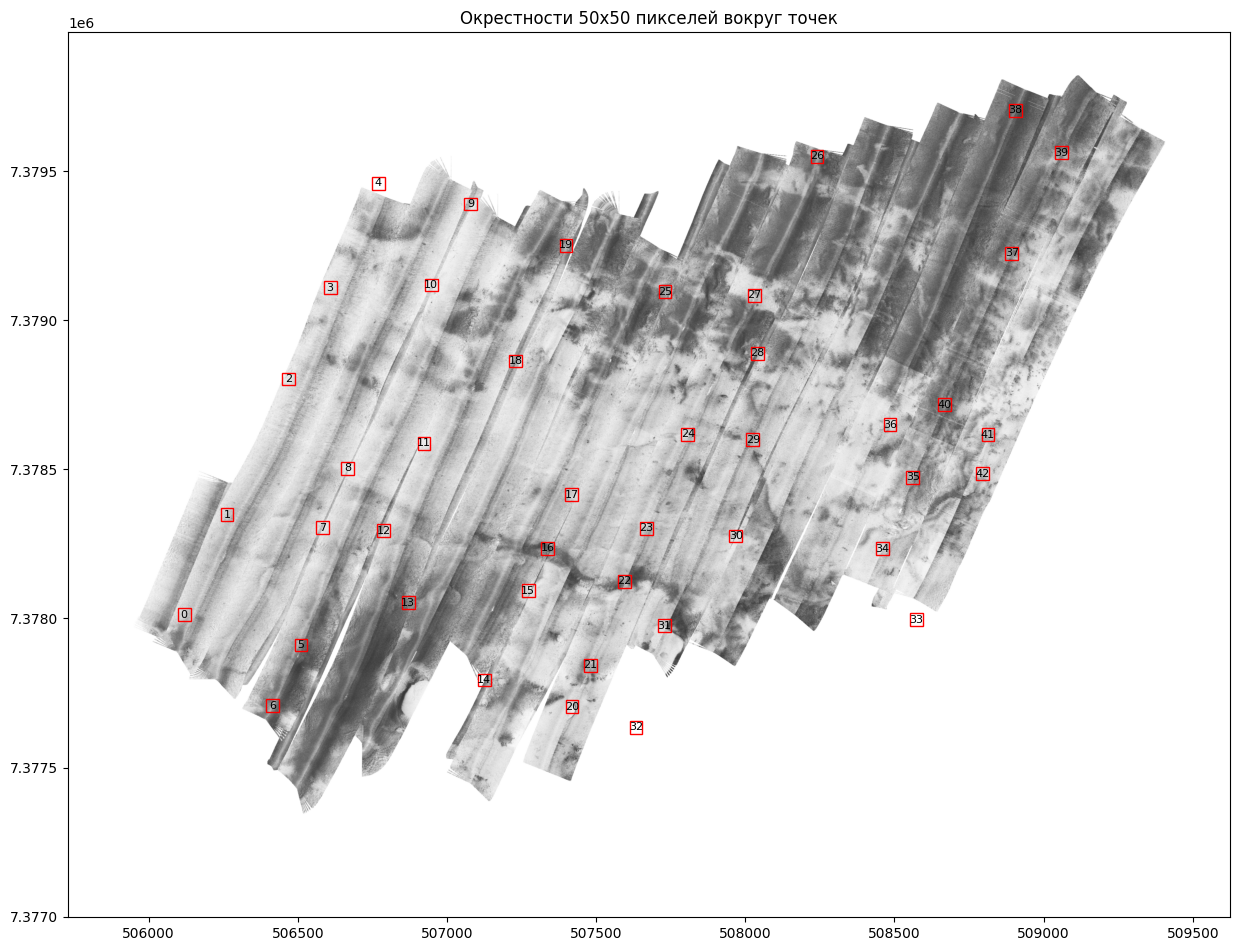

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.patches import Rectangle

# Размер окрестности (5x5 пикселей)
window_size = 50
half_window = window_size // 2  # = 2 (окрестность 2 пикселя в каждую сторону)

with rasterio.open("/content/drive/MyDrive/gazprom_data/00_SideScanSonar.tif") as src:
    fig, ax = plt.subplots(figsize=(15, 15))

    # Отображение растрового изображения
    show(src, ax=ax, cmap='gray')

    for idx, row in gdf.iterrows():
        x, y = row.geometry.x, row.geometry.y
        # Преобразование координат в индексы пикселей
        px, py = rasterio.transform.rowcol(src.transform, x, y)

        # Проверка, чтобы окрестность не выходила за границы
        if (px - half_window >= 0 and px + half_window < src.height and
            py - half_window >= 0 and py + half_window < src.width):

            # Координаты углов в пикселях
            x_min = py - half_window
            x_max = py + half_window + 1  # +1 чтобы включить последний пиксель
            y_min = px - half_window
            y_max = px + half_window + 1

            # Преобразование обратно в географические координаты
            left_bottom = src.transform * (x_min, y_min)
            right_top = src.transform * (x_max, y_max)

            # Создание прямоугольника
            rect = Rectangle(
                (left_bottom[0], left_bottom[1]),
                right_top[0] - left_bottom[0],  # ширина
                right_top[1] - left_bottom[1],  # высота
                linewidth=1,
                edgecolor='red',
                facecolor='none'
            )

            ax.add_patch(rect)
            ax.text(x, y, str(idx), color='black', fontsize=8, ha='center', va='center')
        else:
            print(f"Точка {idx} пропущена: выходит за границы изображения")

plt.title(f"Окрестности {window_size}x{window_size} пикселей вокруг точек")
plt.show()

In [ ]:
import rasterio
import pandas as pd
import numpy as np

# Параметры
window_size = 50
step = 50
half_window = window_size // 2

with rasterio.open("/content/drive/MyDrive/gazprom_data/00_SideScanSonar.tif") as src:
    # Получаем разрешение пикселя
    pixel_res_x, pixel_res_y = src.res

    # Создаем список для данных
    data = []
    point_id = 0

    # Генерируем точки с проверкой границ
    for y in range(half_window, src.height - half_window, step):
        for x in range(half_window, src.width - half_window, step):
            # Читаем окрестность 50x50
            window = ((y - half_window, y + half_window),
                     (x - half_window, x + half_window))
            patch = src.read(1, window=window)

            # Рассчитываем метрики
            mean_intensity = np.mean(patch)
            contrast = np.std(patch)  # Контраст как стандартное отклонение

            # Географические координаты центра
            lon, lat = src.xy(y, x)  # Центр окна

            data.append({
                "point_id": point_id,
                "x": lon,
                "y": lat,
                "mean_intensity": mean_intensity,
                "contrast": contrast
            })
            point_id += 1

# Создаем DataFrame
df = pd.DataFrame(data)
df.to_excel("points_dataset.xlsx", index=False)
df.head()

point_id              x             y  mean_intensity  contrast
0         0  505750.948274  7.379944e+06           255.0       0.0
1         1  505793.139982  7.379944e+06           255.0       0.0
2         2  505835.331690  7.379944e+06           255.0       0.0
3         3  505877.523398  7.379944e+06           255.0       0.0
4         4  505919.715106  7.379944e+06           255.0       0.0

# Интеграция данных гранулометрии

In [ ]:
import pandas as pd
import geopandas as gpd

# Загрузка данных гранулометрии
granulometry = pd.read_excel(
    "/content/drive/MyDrive/gazprom_data/full_table.xlsx",
    sheet_name="Gran. sost 2021",
    header=0
)

# Переименование ключевого столбца в данных гранулометрии
granulometry = granulometry.rename(columns={"№ станции (точки)": "Точка"})

# Унификация формата названий точек: добавление префикса "WS-"
granulometry["№ станции (точки)"] = "WS-" + granulometry["Точка"].astype(str)

# Проверка столбцов
print("Столбцы в геоданных (gdf):", gdf.columns.tolist())
print("Столбцы в гранулометрии:", granulometry.columns.tolist())

# Объединение данных
merged_data = gdf.merge(
    granulometry,
    on="№ станции (точки)",
    how="left",
    suffixes=("_глбо", "_гран")
)

# Проверка пропущенных значений
print("\nПропущенные данные:\n", merged_data.isnull().sum())

# Удаление строк с пропусками ключевых параметров
key_columns = ["Пелит <1-5 мкм, %", "Алеврит 5-10 мкм, %", "Алеврит 10-50 мкм, %"]
merged_data = merged_data.dropna(subset=key_columns)

Столбцы в геоданных (gdf): ['№пп', 'Год пробоотбора', '№ станции (точки)', '№ для карты', 'Unnamed: 4', 'X (UTM 36N)', 'Y (UTM 36N)', 'geometry', 'mean_intensity', 'contrast']
Столбцы в гранулометрии: ['Точка', 'Координата X (UTM 36N)', 'Координата Y (UTM 36N)', 'Глубина моря, м', 'Vmax, см/с', 'Пелит <1-5 мкм, %', 'Алеврит 5-10 мкм, %', 'Алеврит 10-50 мкм, %', 'т-з песок 50-100 мкм, %', 'м-з песок 100-250 мкм, %', 'с-з песок 250-500 мкм, %', 'к-з песок 500-1000 мкм, %', '№ станции (точки)']

Пропущенные данные:
 №пп                           0
Год пробоотбора               0
№ станции (точки)             0
№ для карты                   0
Unnamed: 4                    0
X (UTM 36N)                   0
Y (UTM 36N)                   0
geometry                      0
mean_intensity                0
contrast                      0
Точка                         0
Координата X (UTM 36N)        0
Координата Y (UTM 36N)        0
Глубина моря, м               0
Vmax, см/с                   13
П

In [ ]:
# Переименование столбцов на английский язык
merged_data = merged_data.rename(
    columns={
        'Глубина моря, м': 'sea_depth_m',
        'Vmax, см/с': 'Vmax_cm_s',
    }
)

print(merged_data.head())

   №пп  Год пробоотбора № станции (точки) № для карты Unnamed: 4  \
0  1.0           2021.0        WS-2021_1K      WS.01K        01K   
1  2.0           2021.0        WS-2021_2K      WS.02K        02K   
2  3.0           2021.0        WS-2021_3K      WS.03K        03K   
3  4.0           2021.0        WS-2021_4K      WS.04K        04K   
4  5.0           2021.0        WS-2021_5K      WS.05K        05K   

    X (UTM 36N)   Y (UTM 36N)                        geometry  mean_intensity  \
0  506118.75890  7.378013e+06   POINT (506118.759 7378013.12)      203.673587   
1  506261.94920  7.378349e+06  POINT (506261.949 7378348.604)      203.677047   
2  506468.88347  7.378803e+06   POINT (506468.883 7378802.75)      227.411765   
3  506608.10000  7.379110e+06     POINT (506608.1 7379109.65)      225.068435   
4  506769.65000  7.379459e+06    POINT (506769.65 7379458.84)      255.000000   

    contrast  ... Координата Y (UTM 36N)  sea_depth_m  Vmax_cm_s  \
0  45.473725  ...           7.378013

# Выделение признаков из изображений

In [ ]:
import os
import re
import pandas as pd

# Список точек в датасете (формат: "WS-2021_XK")
points_in_dataset = merged_data["№ станции (точки)"].unique().tolist()

# Словарь для сопоставления
image_to_point = {}

# Путь к папке GladiusPhoto
image_dir = "/content/drive/MyDrive/gazprom_data/GladiusPhoto"

# Проход по всем подпапкам
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)

    # Извлечение номера точки из названия папки
    match = re.search(r'Точка (\d+)', folder)
    if match:
        point_number = int(match.group(1))
        point_id = f"WS-2021_{point_number}K"

        # Проверка наличия точки в датасете
        if point_id in points_in_dataset:
            # Сбор изображений внутри папки
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith((".jpeg", ".jpg", ".png")):
                    img_path = os.path.join(folder_path, img_file)
                    image_to_point[img_path] = point_id
        else:
            print(f"Точка {point_id} отсутствует в датасете.")

# Вывод результатов
print("Сопоставленные изображения:")
for img, point in image_to_point.items():
    print(f"{img} → {point}")

Точка WS-2021_7K отсутствует в датасете.
Сопоставленные изображения:
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 38, гл. 28 м/GLDS0725_110212301.jpeg → WS-2021_38K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 38, гл. 28 м/GLDS0725_110228792.jpeg → WS-2021_38K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 38, гл. 28 м/GLDS0725_110456707.jpeg → WS-2021_38K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 38, гл. 28 м/GLDS0725_110458078.jpeg → WS-2021_38K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 27, гл. 8-10 м/GLDS0725_104006292.jpeg → WS-2021_27K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 27, гл. 8-10 м/GLDS0725_104012592.jpeg → WS-2021_27K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 27, гл. 8-10 м/GLDS0725_104042763.jpeg → WS-2021_27K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 27, гл. 8-10 м/GLDS0725_104047876.jpeg → WS-2021_27K
/content/drive/MyDrive/gazprom_data/GladiusPhoto/Точка 27, гл. 8-10 м/GLDS0

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np

# 1. Загрузка модели ResNet50 с Global Average Pooling
base_model = ResNet50(weights="imagenet", include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

# 2. Извлечение признаков из изображений
features = {}
resnet_feature_size = 2048  # Размерность выходного вектора ResNet50 + GAP

for img_path, point_id in image_to_point.items():
    try:
        # Загрузка изображения и проверка размера
        img = image.load_img(img_path, target_size=(224, 224))

        # Преобразование в массив и расширение размерности
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Нормализация пикселей для ResNet50
        x = preprocess_input(x)  # Центрирование относительно ImageNet

        # Получение признаков
        features_vector = model.predict(x, verbose=0).flatten()

        # Проверка размерности
        if features_vector.shape[0] != resnet_feature_size:
            raise ValueError(f"Неверная размерность вектора: {features_vector.shape}")

        features[point_id] = features_vector

    except Exception as e:
        print(f"Ошибка обработки {img_path}: {str(e)}")
        features[point_id] = np.zeros(resnet_feature_size)  # Заполнение нулями

# 3. Создание столбцов для ResNet-признаков
resnet_columns = [f"resnet_{i}" for i in range(resnet_feature_size)]

# 4. Добавление признаков в датасет
for point_id in merged_data["№ станции (точки)"].unique():
    if point_id in features:
        merged_data.loc[merged_data["№ станции (точки)"] == point_id, resnet_columns] = features[point_id]
    else:
        merged_data.loc[merged_data["№ станции (точки)"] == point_id, resnet_columns] = 0

# 5. Проверка результата
print("Итоговые столбцы датасета:")
print(merged_data.columns.tolist())

print("\nПример данных (первые 5 признаков):")
print(merged_data[["№ станции (точки)"] + resnet_columns[:5]].head())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Итоговые столбцы датасета:
['№пп', 'Год пробоотбора', '№ станции (точки)', '№ для карты', 'Unnamed: 4', 'X (UTM 36N)', 'Y (UTM 36N)', 'geometry', 'mean_intensity', 'contrast', 'Точка', 'Координата X (UTM 36N)', 'Координата Y (UTM 36N)', 'sea_depth_m', 'Vmax_cm_s', 'Пелит <1-5 мкм, %', 'Алеврит 5-10 мкм, %', 'Алеврит 10-50 мкм, %', 'т-з песок 50-100 мкм, %', 'м-з песок 100-250 мкм, %', 'с-з песок 250-500 мкм, %', 'к-з песок 500-1000 мкм, %', 'resnet_0', 'resnet_1', 'resnet_2', 'resnet_3', 'resnet_4', 'resnet_5', 'resnet_6', 'resnet_7', 'resnet_8', 'resnet_9', 'resnet_10', 'resnet_11', 'resnet_12', 'resnet_13', 'resnet_14', 'resnet_15', 'resnet_16', 'resnet_17', 'resnet_18', 'resnet_19', 'resnet_20', 'resnet_21', 'resnet_22', 'resnet_23', 'resnet_24', 'resnet_25', 'resnet_26', 'resnet_27', 'resnet_28', 'resnet_29', 'resnet_30', 'resnet_31', 'resnet_32', 'resnet_33', 'resnet_34', 'resnet_35', 'resnet_36', 'resnet_37', 'resnet_38', 'resnet

# Проверка результирующего датасета

In [ ]:
# Проверка первых строк объединенного датасета
print("Первые 5 строк объединенного датасета:")
print(merged_data.head())

# Проверка уникальных точек
print("\nУникальные точки в геоданных:", gdf["№ станции (точки)"].nunique())
print("Уникальные точки в гранулометрии:", granulometry["Точка"].nunique())

# Проверка совпадения координат
sample_point = merged_data.iloc[0]
print("\nПример точки (WS-2021_1K):")
print("X (из геоданных):", sample_point["X (UTM 36N)"])
print("X (из гранулометрии):", sample_point["Координата X (UTM 36N)"])
print("Y (из геоданных):", sample_point["Y (UTM 36N)"])
print("Y (из гранулометрии):", sample_point["Координата Y (UTM 36N)"])

# Проверка наличия ключевых параметров гранулометрии
print("\nНаличие ключевых параметров:")
print("Пелит <1-5 мкм, %:", "Пелит <1-5 мкм, %" in merged_data.columns)
print("Алеврит 5-10 мкм, %:", "Алеврит 5-10 мкм, %" in merged_data.columns)
print("Алеврит 10-50 мкм, %:", "Алеврит 10-50 мкм, %" in merged_data.columns)

Первые 5 строк объединенного датасета:
   №пп  Год пробоотбора № станции (точки) № для карты Unnamed: 4  \
0  1.0           2021.0        WS-2021_1K      WS.01K        01K   
1  2.0           2021.0        WS-2021_2K      WS.02K        02K   
2  3.0           2021.0        WS-2021_3K      WS.03K        03K   
3  4.0           2021.0        WS-2021_4K      WS.04K        04K   
4  5.0           2021.0        WS-2021_5K      WS.05K        05K   

    X (UTM 36N)   Y (UTM 36N)                        geometry  mean_intensity  \
0  506118.75890  7.378013e+06   POINT (506118.759 7378013.12)      203.673587   
1  506261.94920  7.378349e+06  POINT (506261.949 7378348.604)      203.677047   
2  506468.88347  7.378803e+06   POINT (506468.883 7378802.75)      227.411765   
3  506608.10000  7.379110e+06     POINT (506608.1 7379109.65)      225.068435   
4  506769.65000  7.379459e+06    POINT (506769.65 7379458.84)      255.000000   

    contrast  ... Координата Y (UTM 36N)  sea_depth_m  Vmax_cm_s 

# Удаление пропусков

In [ ]:
# Шаг 1: Определение числовых признаков
numeric_features = [
    "mean_intensity",
    "contrast",
    "sea_depth_m",
    "Vmax_cm_s",
    "Пелит <1-5 мкм, %",
    "Алеврит 5-10 мкм, %",
    "Алеврит 10-50 мкм, %",
    "т-з песок 50-100 мкм, %",
    "м-з песок 100-250 мкм, %",
    "с-з песок 250-500 мкм, %",
    "к-з песок 500-1000 мкм, %"
]

# Шаг 2: Удаление пропусков
merged_data_clean = merged_data.dropna(subset=numeric_features)

merged_data_filled = merged_data.copy()
merged_data_filled[numeric_features] = merged_data_filled[numeric_features].fillna(0)

# Шаг 4: Проверка
print("Первые строки после нормализации:")
print(merged_data_filled[numeric_features].head())

Первые строки после нормализации:
   mean_intensity   contrast  sea_depth_m  Vmax_cm_s  Пелит <1-5 мкм, %  \
0      203.673587  45.473725           17        0.0               19.5   
1      203.677047  57.060784           21       10.0               18.8   
2      227.411765  60.492549           18       17.0               50.5   
3      225.068435  19.658039           19       24.0               20.1   
4      255.000000   0.000000           18       12.0               11.7   

   Алеврит 5-10 мкм, %  Алеврит 10-50 мкм, %  т-з песок 50-100 мкм, %  \
0                 15.2                  44.1                      3.6   
1                 16.4                  40.5                     16.0   
2                 22.0                  27.5                      0.0   
3                 20.5                  56.0                      0.6   
4                 11.4                  52.7                     14.4   

   м-з песок 100-250 мкм, %  с-з песок 250-500 мкм, %  \
0                  

# Сохранение финального датасета

In [ ]:
# Экспорт в Excel
merged_data_filled.to_excel("sum_dataset.xlsx", index=False)

# Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 1. Загрузка данных
df = pd.read_excel('sum_dataset.xlsx', sheet_name='Sheet1')

# 2. Подготовка данных
resnet_features = [f'resnet_{i}' for i in range(2048)]
geo_features = ['X (UTM 36N)', 'Y (UTM 36N)', 'mean_intensity', 'contrast', "sea_depth_m", "Vmax_cm_s"]
targets = [
    'Пелит <1-5 мкм, %',
    'Алеврит 5-10 мкм, %',
    'Алеврит 10-50 мкм, %',
    'т-з песок 50-100 мкм, %',
    'м-з песок 100-250 мкм, %',
    'с-з песок 250-500 мкм, %',
    'к-з песок 500-1000 мкм, %'
]
X = df[resnet_features + geo_features].values
y = df[targets].values

# Предъобработка данных

count    43.000000
mean      0.216279
std       1.040131
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       6.100000
Name: к-з песок 500-1000 мкм, %, dtype: float64


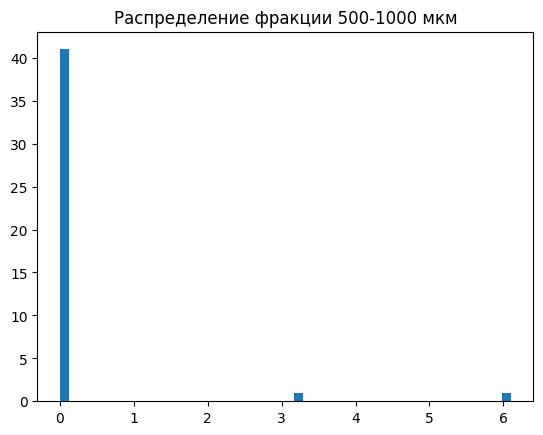

Пример масштабированных значений: [-0.21039539 -0.21039539 -0.21039539 -0.21039539  5.72365964 -0.21039539
 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539
  2.90255151 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539
 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539
 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539 -0.21039539
 -0.21039539 -0.21039539 -0.21039539 -0.21039539]
Обратное преобразование: [0.  0.  0.  0.  6.1 0.  0.  0.  0.  0.  0.  0.  3.2 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [ ]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)
# Проверяем распределение целевой переменной
print(df['к-з песок 500-1000 мкм, %'].describe())
plt.hist(df['к-з песок 500-1000 мкм, %'], bins=50)
plt.title('Распределение фракции 500-1000 мкм')
plt.show()

# Проверяем масштабирование
print("Пример масштабированных значений:", y_train[:, -1])
print("Обратное преобразование:", scaler_y.inverse_transform(y_train)[:, -1])

# Построение модели

In [ ]:
def build_model(input_shape, output_shape):
    inputs = Input(shape=(input_shape,))

    x = Dense(1024, activation='relu')(inputs)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu')(x)

    outputs = Dense(output_shape, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(X_train.shape[1], y_train.shape[1])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 2054)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1024)           │     2,104,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,762,247 (10.54 MB)

 Trainable params: 2,762,247 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.3192 - mae: 1.0526 - val_loss: 0.9798 - val_mae: 0.7833
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 4.4302 - mae: 1.3755 - val_loss: 0.5625 - val_mae: 0.5323
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 2.1421 - mae: 0.9840 - val_loss: 0.5595 - val_mae: 0.6364
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 2.0707 - mae: 0.9917 - val_loss: 0.6212 - val_mae: 0.6866
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 2.7458 - mae: 1.1303 - val_loss: 0.8108 - val_mae: 0.7267
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.7516 - mae: 0.9677 - val_loss: 0.7442 - val_mae: 0.6512
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 2.6147 - mae: 1.0156 - val_loss: 0.6178 - val_mae: 0.5298
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 3.2610 - mae: 1.1052 - val_loss: 0.5076 - val_mae: 0.5162
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 2.0222 -

# Визуализация и оценка

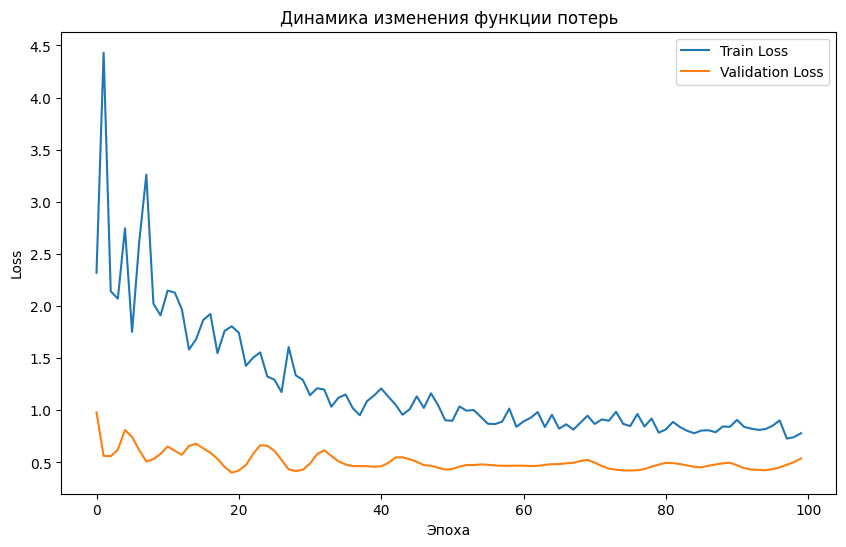


Общий Test Loss: 0.6119
Общий Test MAE: 0.5612


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Динамика изменения функции потерь')
plt.ylabel('Loss')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nОбщий Test Loss: {test_loss:.4f}")
print(f"Общий Test MAE: {test_mae:.4f}")

# Оценка на тестовом датасете

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


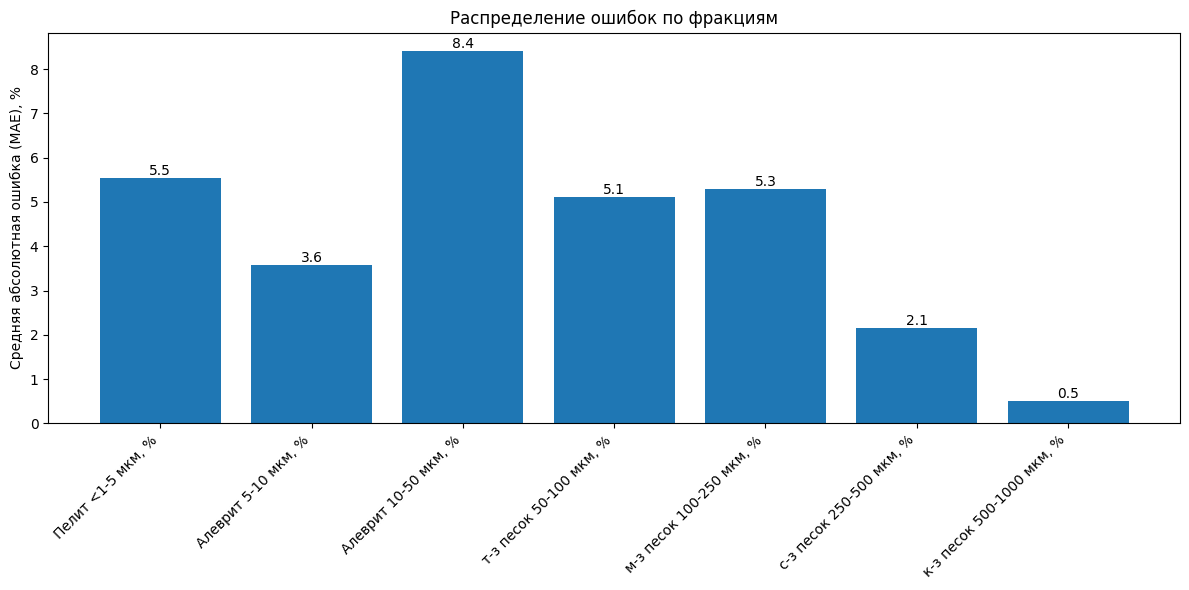


Детализация MAE по фракциям:
- Пелит <1-5 мкм, %: 5.55%
- Алеврит 5-10 мкм, %: 3.59%
- Алеврит 10-50 мкм, %: 8.41%
- т-з песок 50-100 мкм, %: 5.11%
- м-з песок 100-250 мкм, %: 5.29%
- с-з песок 250-500 мкм, %: 2.14%
- к-з песок 500-1000 мкм, %: 0.50%


In [ ]:
# Предсказание для всего тестового набора
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_scaled)

# Расчет MAE для каждого признака
mae_per_feature = np.mean(np.abs(y_true - y_pred), axis=0)

# Визуализация MAE по признакам
plt.figure(figsize=(12, 6))
bars = plt.bar(targets, mae_per_feature)
plt.ylabel('Средняя абсолютная ошибка (MAE), %')
plt.title('Распределение ошибок по фракциям')
plt.xticks(rotation=45, ha='right')

# Добавление значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Вывод значений MAE в консоль
print("\nДетализация MAE по фракциям:")
for target, mae in zip(targets, mae_per_feature):
    print(f"- {target}: {mae:.2f}%")

# Пример предсказания

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Оценка модели на всем наборе данных:
                             MAE      MSE     R2    RMSE
Пелит <1-5 мкм, %          5.547   65.599  0.310   8.099
Алеврит 5-10 мкм, %        3.585   20.754  0.266   4.556
Алеврит 10-50 мкм, %       8.406  135.594  0.289  11.645
т-з песок 50-100 мкм, %    5.111   62.022  0.087   7.875
м-з песок 100-250 мкм, %   5.289   57.926  0.458   7.611
с-з песок 250-500 мкм, %   2.143    9.357  0.702   3.059
к-з песок 500-1000 мкм, %  0.504    0.826  0.219   0.909


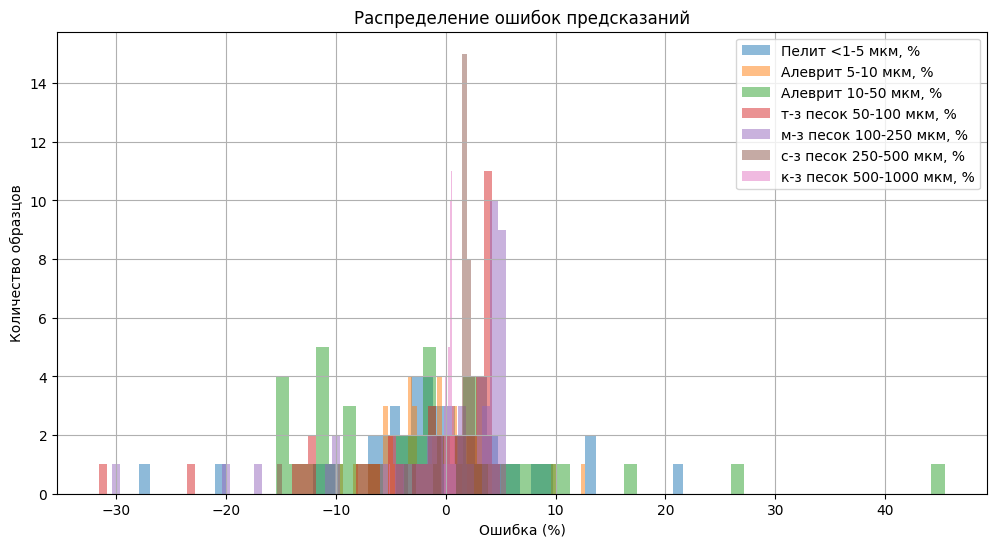


Модель успешно оценена на всем наборе данных. Результаты сохранены в full_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Предсказание на всем наборе данных
y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_scaled)

# 2. Вычисление метрик
metrics = {
    'MAE': mean_absolute_error(y_true, y_pred, multioutput='raw_values'),
    'MSE': mean_squared_error(y_true, y_pred, multioutput='raw_values'),
    'R2': r2_score(y_true, y_pred, multioutput='raw_values')
}

# 3. Создание DataFrame с метриками
metrics_df = pd.DataFrame(metrics, index=targets)
metrics_df['RMSE'] = np.sqrt(metrics_df['MSE'])

print("\nОценка модели на всем наборе данных:")
print(metrics_df.round(3))

# 4. Визуализация распределения ошибок
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, target in enumerate(targets):
    errors = y_pred[:,i] - y_true[:,i]
    plt.hist(errors, bins=50, alpha=0.5, label=target)

plt.title('Распределение ошибок предсказаний')
plt.xlabel('Ошибка (%)')
plt.ylabel('Количество образцов')
plt.legend()
plt.grid(True)
plt.show()

# 5. Сохранение полных предсказаний
full_predictions = pd.DataFrame({
    'X': df['X (UTM 36N)'],
    'Y': df['Y (UTM 36N)'],
    **{f'True_{target}': y_true[:,i] for i, target in enumerate(targets)},
    **{f'Pred_{target}': y_pred[:,i] for i, target in enumerate(targets)}
})

full_predictions.to_csv('full_predictions.csv', index=False)

# 6. Обновленная функция предсказания с проверкой данных
def predict_geodata(grid_df):
    """
    Улучшенная функция предсказания с проверкой входных данных
    """
    required_columns = resnet_features + geo_features
    missing_cols = [col for col in required_columns if col not in grid_df.columns]

    if missing_cols:
        raise ValueError(f"Отсутствуют необходимые колонки: {missing_cols}")

    try:
        grid_scaled = scaler_X.transform(grid_df[required_columns])
        preds_scaled = model.predict(grid_scaled)
        preds = scaler_y.inverse_transform(preds_scaled)

        return pd.DataFrame({
            'X': grid_df['X (UTM 36N)'],
            'Y': grid_df['Y (UTM 36N)'],
            **{target: preds[:,i] for i, target in enumerate(targets)}
        })

    except Exception as e:
        print("Ошибка при предсказании:")
        raise e

# Пример использования:
# full_evaluation = predict_geodata(df)
# full_evaluation.to_csv('complete_evaluation.csv', index=False)

print("\nМодель успешно оценена на всем наборе данных. Результаты сохранены в full_predictions.csv")

# Вторая версия модели

# Загрузка датасета

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_excel('sum_dataset.xlsx')
df_test = pd.read_excel('points_dataset.xlsx')

# Подготовка данных
geo_features = ['mean_intensity', 'contrast']
targets = [
    'Пелит <1-5 мкм, %',
    'Алеврит 5-10 мкм, %',
    'Алеврит 10-50 мкм, %',
    'т-з песок 50-100 мкм, %',
    'м-з песок 100-250 мкм, %',
    'с-з песок 250-500 мкм, %',
    'к-з песок 500-1000 мкм, %'
]
X = df[geo_features].values
y = df[targets].values

# Мастштабирование и разделение

In [ ]:
# Масштабирование признаков
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42
)

# Инициализация модели

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    loss_function='MultiRMSE',
    iterations=1500,
    depth=8,
    learning_rate=0.05,
    eval_metric='MultiRMSE',
    early_stopping_rounds=50,
    verbose=100
)

# Обучение

In [ ]:
history = model.fit(
    X_train, y_train,
    plot=False,
    verbose=False
)

# Визуализация обучения

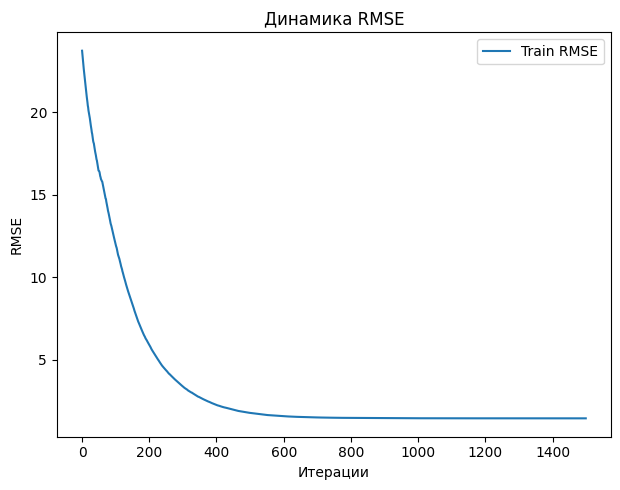


Test RMSE: 12.0960
Test MAE: 8.2709

Пример предсказания: [ 8.49680599  2.30510375 16.11040945 11.10741312 37.09217782 18.79165429
  6.09643557]
Сумма предсказаний: 100.00%


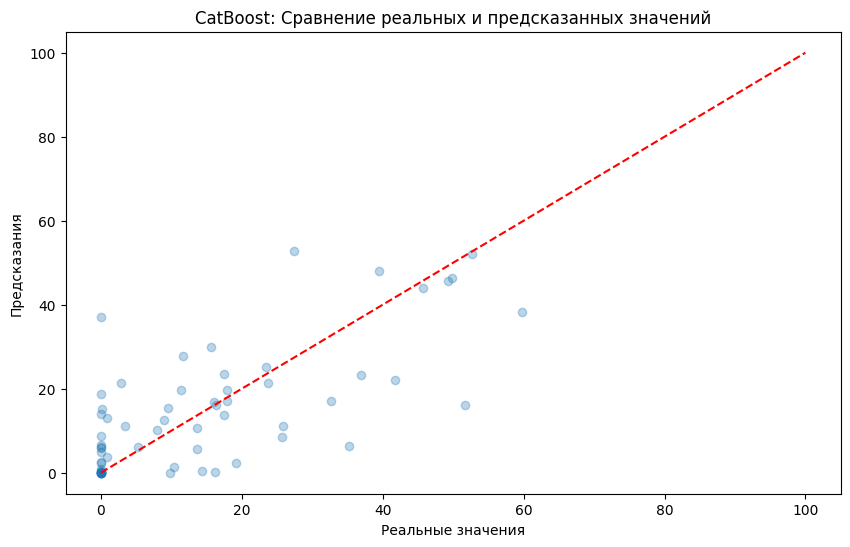

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Извлечение метрик из истории обучения
evals_result = model.get_evals_result()

train_rmse = evals_result['learn']['MultiRMSE']
# Визуализация аналогичная PyTorch версии
plt.figure(figsize=(12, 5))

# График RMSE
plt.subplot(1, 2, 1)
plt.plot(train_rmse, label='Train RMSE')
plt.title('Динамика RMSE')
plt.ylabel('RMSE')
plt.xlabel('Итерации')
plt.legend()

plt.tight_layout()
plt.show()

# Оценка на тестовом наборе с постобработкой
test_pred_raw = model.predict(X_test)
test_pred = np.clip(test_pred_raw, 0, None)
sums = test_pred.sum(axis=1)
sums[sums == 0] = 1e-6
test_pred_normalized = (test_pred / sums[:, np.newaxis]) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_normalized))
test_mae = mean_absolute_error(y_test, test_pred_normalized)

print(f"\nTest RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Проверка суммы выходов
sample = X_test[0:1]
sample_pred_raw = model.predict(sample)
sample_pred = np.clip(sample_pred_raw, 0, None)
sum_sample = sample_pred.sum()
if sum_sample == 0:
    sum_sample = 1e-6
sample_pred_normalized = (sample_pred / sum_sample) * 100

print(f"\nПример предсказания: {sample_pred_normalized[0]}")
print(f"Сумма предсказаний: {np.sum(sample_pred_normalized):.2f}%")

# Дополнительная визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), test_pred_normalized.flatten(), alpha=0.3)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title('CatBoost: Сравнение реальных и предсказанных значений')
plt.show()

# Визуализация предсказаний

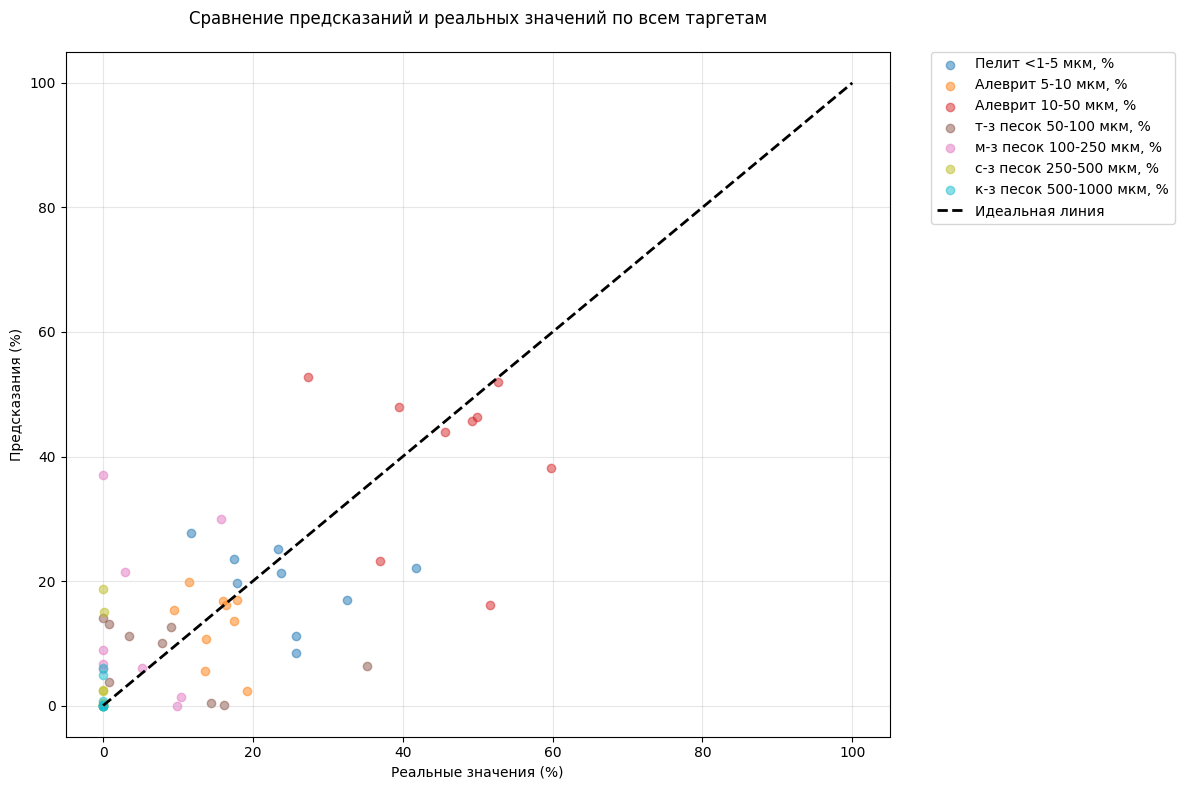

<ipython-input-17-962102763a69>:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors, labels=targets)


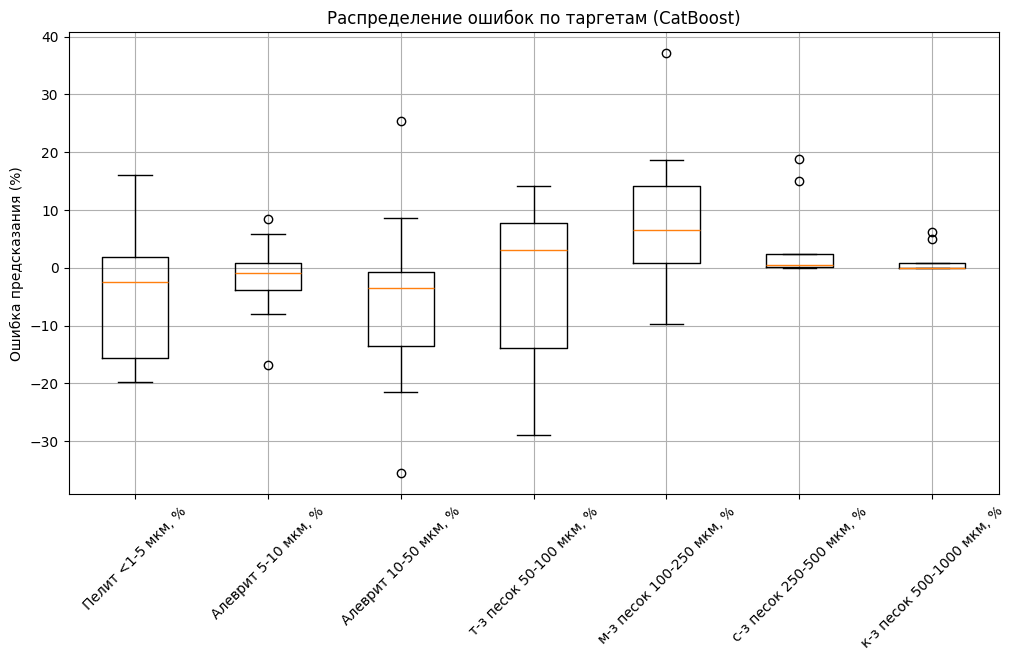

Таргет                         | MAE        | RMSE       | R²        
-------------------------------------------------------
Пелит <1-5 мкм, %              | 10.59      | 12.70      | -1.32     
Алеврит 5-10 мкм, %            | 5.32       | 7.30       | -4.84     
Алеврит 10-50 мкм, %           | 12.70      | 17.19      | -2.48     
т-з песок 50-100 мкм, %        | 11.30      | 13.83      | -0.70     
м-з песок 100-250 мкм, %       | 12.30      | 15.83      | -7.32     
с-з песок 250-500 мкм, %       | 4.36       | 8.09       | -66306.58 
к-з песок 500-1000 мкм, %      | 1.32       | 2.62       | 0.00      

Средние значения               | 10.44      | 13.37      | -3.33     


In [ ]:
# Получаем предсказания для тестового набора с постобработкой
test_pred_raw = model.predict(X_test)
test_pred = np.clip(test_pred_raw, 0, None)
sums = test_pred.sum(axis=1)
sums[sums == 0] = 1e-6
predictions = (test_pred / sums[:, np.newaxis]) * 100

# Создаем общий график с цветовым разделением
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(targets)))  # Генерация цветовой палитры

# Рисуем точки для каждого таргета
for i, target in enumerate(targets):
    plt.scatter(y_test[:, i],
                predictions[:, i],
                color=colors[i],
                alpha=0.5,
                label=target)

# Добавляем идеальную линию
plt.plot([0, 100], [0, 100], '--k', linewidth=2, label='Идеальная линия')

# Настройки оформления
plt.title('Сравнение предсказаний и реальных значений по всем таргетам', pad=20)
plt.xlabel('Реальные значения (%)')
plt.ylabel('Предсказания (%)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Установка одинаковых пределов для осей
plt.xlim(-5, 105)
plt.ylim(-5, 105)

plt.tight_layout()
plt.show()

# Остальной код с метриками и распределением ошибок остается без изменений
# Визуализация распределения ошибок
errors = predictions - y_test

plt.figure(figsize=(12, 6))
plt.boxplot(errors, labels=targets)
plt.title('Распределение ошибок по таргетам (CatBoost)')
plt.ylabel('Ошибка предсказания (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Вывод метрик
print("{:<30} | {:<10} | {:<10} | {:<10}".format("Таргет", "MAE", "RMSE", "R²"))
print("-" * 55)
for i, target in enumerate(targets):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    r2 = r2_score(y_test[:, i], predictions[:, i])

    print("{:<30} | {:<10.2f} | {:<10.2f} | {:<10.2f}".format(
        target, mae, rmse, r2))

# Вывод средних метрик
n_targets = 5
avg_mae = np.mean([mean_absolute_error(y_test[:, i], predictions[:, i])
                 for i in range(n_targets)])
avg_rmse = np.mean([np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
                  for i in range(n_targets)])
avg_r2 = np.mean([r2_score(y_test[:, i], predictions[:, i])
                for i in range(n_targets)])

print("\n{:<30} | {:<10.2f} | {:<10.2f} | {:<10.2f}".format(
    "Средние значения", avg_mae, avg_rmse, avg_r2))

# Создние датасета предсказаний

In [ ]:
import numpy as np
import pandas as pd
df_test = pd.read_excel('points_dataset.xlsx')

# Подготовка данных
geo_features = ['mean_intensity', 'contrast']
targets = [
    'Пелит <1-5 мкм, %',
    'Алеврит 5-10 мкм, %',
    'Алеврит 10-50 мкм, %',
    'т-з песок 50-100 мкм, %',
    'м-з песок 100-250 мкм, %',
    'с-з песок 250-500 мкм, %',
    'к-з песок 500-1000 мкм, %'
]
X = df_test[geo_features].values
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Инициализируем пустой список для хранения предсказаний
all_predictions = []

# Проходим по всем образцам в X_scaled
for sample in X_scaled:
    # Делаем предсказание для одного образца
    sample_pred_raw = model.predict(sample.reshape(1, -1))

    # Обрезаем отрицательные значения
    sample_pred = np.clip(sample_pred_raw, 0, None)

    # Нормализуем сумму до 100%
    sum_sample = sample_pred.sum()
    if sum_sample == 0:
        sum_sample = 1e-6
    sample_pred_normalized = (sample_pred / sum_sample) * 100

    # Добавляем в список
    all_predictions.append(sample_pred_normalized.flatten())

# Создаем DataFrame с названиями столбцов
target_columns = [
    'Пелит <1-5 мкм, %',
    'Алеврит 5-10 мкм, %',
    'Алеврит 10-50 мкм, %',
    'т-з песок 50-100 мкм, %',
    'м-з песок 100-250 мкм, %',
    'с-з песок 250-500 мкм, %',
    'к-з песок 500-1000 мкм, %'
]

result_df = pd.DataFrame(all_predictions, columns=target_columns)
result_df.head()

Пелит <1-5 мкм, %  Алеврит 5-10 мкм, %  Алеврит 10-50 мкм, %  \
0          23.421572            16.635782             40.461811   
1          23.421572            16.635782             40.461811   
2          23.421572            16.635782             40.461811   
3          23.421572            16.635782             40.461811   
4          23.421572            16.635782             40.461811   

   т-з песок 50-100 мкм, %  м-з песок 100-250 мкм, %  \
0                13.875112                  5.605724   
1                13.875112                  5.605724   
2                13.875112                  5.605724   
3                13.875112                  5.605724   
4                13.875112                  5.605724   

   с-з песок 250-500 мкм, %  к-з песок 500-1000 мкм, %  
0                       0.0                        0.0  
1                       0.0                        0.0  
2                       0.0                        0.0  
3                       0.0                        0.0  
4                       0.0                        0.0

# Объединение данных

In [ ]:
import pandas as pd

# Предполагаем, что result_df уже создан как в предыдущем ответе

# Выбираем исходные колонки БЕЗ целевых переменных (они заменяются на предсказанные)
selected_columns = ['point_id', 'x', 'y']

# Создаем базовый датасет
filtered_df = df_test[selected_columns].rename(columns={
    'point_id': 'Точка',
})

# Добавляем предсказанные значения
filtered_df = pd.concat([filtered_df, result_df], axis=1)

# Сохраняем в Excel
filtered_df.to_excel('filtered_dataset.xlsx', index=False)

# Проверка
print(filtered_df.head())
print(f"\nКолонки в финальном датасете: {filtered_df.columns.tolist()}")

   Точка              x             y  Пелит <1-5 мкм, %  Алеврит 5-10 мкм, %  \
0      0  505750.948274  7.379944e+06          23.421572            16.635782   
1      1  505793.139982  7.379944e+06          23.421572            16.635782   
2      2  505835.331690  7.379944e+06          23.421572            16.635782   
3      3  505877.523398  7.379944e+06          23.421572            16.635782   
4      4  505919.715106  7.379944e+06          23.421572            16.635782   

   Алеврит 10-50 мкм, %  т-з песок 50-100 мкм, %  м-з песок 100-250 мкм, %  \
0             40.461811                13.875112                  5.605724   
1             40.461811                13.875112                  5.605724   
2             40.461811                13.875112                  5.605724   
3             40.461811                13.875112                  5.605724   
4             40.461811                13.875112                  5.605724   

   с-з песок 250-500 мкм, %  к-з песок 500-1

# Кластеризация

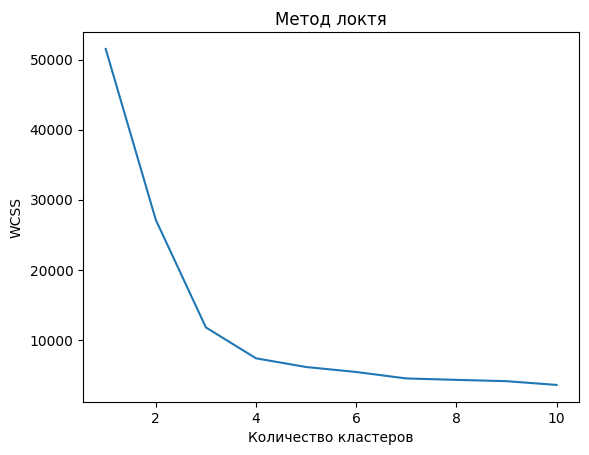

   Точка              x             y  Пелит <1-5 мкм, %  Алеврит 5-10 мкм, %  \
0      0  505750.948274  7.379944e+06          23.421572            16.635782   
1      1  505793.139982  7.379944e+06          23.421572            16.635782   
2      2  505835.331690  7.379944e+06          23.421572            16.635782   
3      3  505877.523398  7.379944e+06          23.421572            16.635782   
4      4  505919.715106  7.379944e+06          23.421572            16.635782   

   Алеврит 10-50 мкм, %  т-з песок 50-100 мкм, %  м-з песок 100-250 мкм, %  \
0             40.461811                13.875112                  5.605724   
1             40.461811                13.875112                  5.605724   
2             40.461811                13.875112                  5.605724   
3             40.461811                13.875112                  5.605724   
4             40.461811                13.875112                  5.605724   

   с-з песок 250-500 мкм, %  к-з песок 500-1

In [ ]:
# Импорт необходимых библиотек
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Подготовка данных для кластеризации
# Исключаем колонку 'Точка' (предполагая, что она содержит строковые значения)
cluster_data = filtered_df.drop(columns=['Точка', 'x', 'y'])

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Определение оптимального числа кластеров (метод локтя)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Визуализация метода локтя (опционально)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Добавление меток кластеров в DataFrame
filtered_df['Cluster'] = clusters

# Сохранение результата
filtered_df.to_excel('filtered_dataset_with_clusters.xlsx', index=False)

# Просмотр результата
print(filtered_df.head())
print(f"\nКолонки в датасете: {filtered_df.columns.tolist()}")

# Статистика по класстерам

Распределение объектов по кластерам:
         count  percentage
Cluster                   
0          599         9.3
1         3877        60.2
2         1761        27.3
3          203         3.2


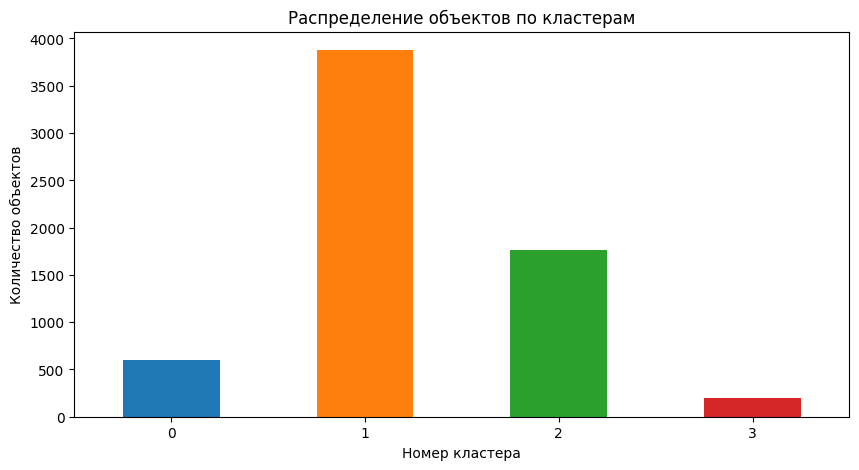

In [ ]:
# Группировка по кластерам и расчет статистик
cluster_stats = filtered_df.groupby('Cluster').agg(
    count=('Cluster', 'count'),
    percentage=('Cluster', lambda x: round(len(x)/len(filtered_df)*100, 1))
    )


# Вывод результатов
print("="*50)
print("Распределение объектов по кластерам:")
print(cluster_stats)

# Дополнительная визуализация распределения
plt.figure(figsize=(10,5))
filtered_df['Cluster'].value_counts().sort_index().plot(
    kind='bar',
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
)
plt.title('Распределение объектов по кластерам')
plt.xlabel('Номер кластера')
plt.ylabel('Количество объектов')
plt.xticks(rotation=0)
plt.show()

In [ ]:
print("Колонки в DataFrame:", filtered_df.columns.tolist())

Колонки в DataFrame: ['Точка', 'x', 'y', 'Пелит <1-5 мкм, %', 'Алеврит 5-10 мкм, %', 'Алеврит 10-50 мкм, %', 'т-з песок 50-100 мкм, %', 'м-з песок 100-250 мкм, %', 'с-з песок 250-500 мкм, %', 'к-з песок 500-1000 мкм, %', 'Cluster']


In [ ]:
from tabulate import tabulate

def print_cluster_stats(filtered_df, numeric_cols):
    # Проверки безопасности
    if 'Cluster' not in filtered_df.columns:
        raise ValueError("Столбец 'Cluster' отсутствует. Выполните кластеризацию перед анализом!")

    # Вычисляем статистики
    stats = filtered_df.groupby('Cluster')[numeric_cols].agg(['min', 'max', 'mean', 'median', 'std']).round(2)

    # Преобразуем структуру данных
    stats_flat = stats.stack(level=0).reset_index().rename(columns={
        'level_1': 'Параметр',
        'Cluster': 'Кластер'
    })

    # Выводим общую информацию
    print(f"\n{'📊 АНАЛИЗ КЛАСТЕРОВ ':━^60}")
    print(f"Всего кластеров: {len(stats)}")
    print(f"Анализируемые параметры: {', '.join(numeric_cols)}")
    print(f"{'':━^60}\n")

    # Вывод по каждому кластеру
    for cluster in sorted(stats.index.unique()):
        print(f"\n🔷 {'КЛАСТЕР ' + str(cluster) + ' ':━^50}")

        # Фильтруем данные для кластера
        cluster_data = stats_flat[stats_flat['Кластер'] == cluster]

        # Создаем таблицу для отображения
        table_data = []
        for param in numeric_cols:
            param_data = cluster_data[cluster_data['Параметр'] == param]
            table_data.append([
                param,
                param_data['min'].values[0],
                param_data['max'].values[0],
                param_data['mean'].values[0],
                param_data['std'].values[0]
            ])

        # Выводим таблицу
        print("\nОсновные характеристики:")
        print(tabulate(table_data,
                      headers=['Параметр', 'Min', 'Max', 'Среднее', 'Станд. отклонение'],
                      tablefmt='pretty',
                      floatfmt=".2f"))

        # Текстовая интерпретация
        print("\n📝 Характеристики кластера:")
        for row in table_data:
            print(f" • {row[0]}: среднее {row[3]} (диапазон {row[1]}-{row[2]})")

        print(f"{'':━^50}")

# Определяем числовые колонки правильно
numeric_cols = [
    'Пелит <1-5 мкм, %',
    'Алеврит 5-10 мкм, %',
    'Алеврит 10-50 мкм, %',
    'т-з песок 50-100 мкм, %',
    'м-з песок 100-250 мкм, %',
    'с-з песок 250-500 мкм, %',
    'к-з песок 500-1000 мкм, %'
]

# Проверяем данные
print("Проверка числовых колонок:", numeric_cols)
print("Типы данных:\n", filtered_df[numeric_cols].dtypes)

# Вызываем функцию
print_cluster_stats(filtered_df, numeric_cols)

Проверка числовых колонок: ['Пелит <1-5 мкм, %', 'Алеврит 5-10 мкм, %', 'Алеврит 10-50 мкм, %', 'т-з песок 50-100 мкм, %', 'м-з песок 100-250 мкм, %', 'с-з песок 250-500 мкм, %', 'к-з песок 500-1000 мкм, %']
Типы данных:
 Пелит <1-5 мкм, %            float64
Алеврит 5-10 мкм, %          float64
Алеврит 10-50 мкм, %         float64
т-з песок 50-100 мкм, %      float64
м-з песок 100-250 мкм, %     float64
с-з песок 250-500 мкм, %     float64
к-з песок 500-1000 мкм, %    float64
dtype: object

━━━━━━━━━━━━━━━━━━━━📊 АНАЛИЗ КЛАСТЕРОВ ━━━━━━━━━━━━━━━━━━━━━
Всего кластеров: 4
Анализируемые параметры: Пелит <1-5 мкм, %, Алеврит 5-10 мкм, %, Алеврит 10-50 мкм, %, т-з песок 50-100 мкм, %, м-з песок 100-250 мкм, %, с-з песок 250-500 мкм, %, к-з песок 500-1000 мкм, %
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


🔷 ━━━━━━━━━━━━━━━━━━━━КЛАСТЕР 0 ━━━━━━━━━━━━━━━━━━━━

Основные характеристики:
+---------------------------+-------+-------+---------+-------------------+
|         Параме

<ipython-input-97-4f8ab6d0db70>:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stats_flat = stats.stack(level=0).reset_index().rename(columns={


# Визуализация карты

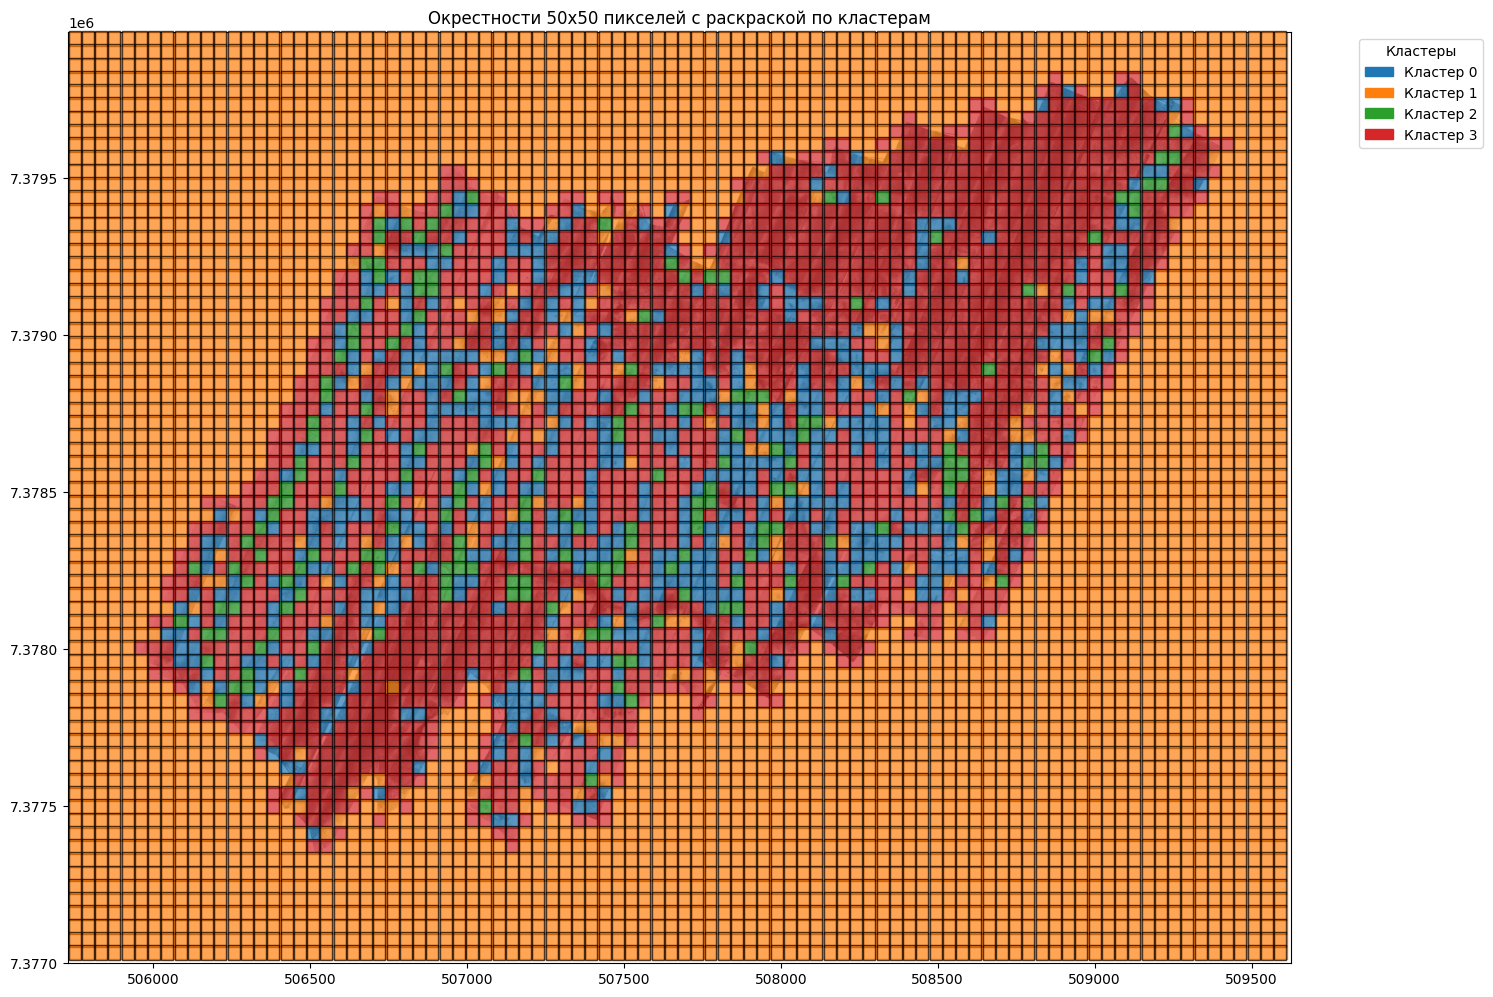

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Загрузка данных с кластерами
filtered_df = pd.read_excel('filtered_dataset_with_clusters.xlsx')

# Создаем цветовую схему для кластеров
cluster_colors = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728'
}

# Размер окрестности
window_size = 50
half_window = window_size // 2

with rasterio.open("/content/drive/MyDrive/gazprom_data/00_SideScanSonar.tif") as src:
    fig, ax = plt.subplots(figsize=(15, 15))

    # Отображение растрового изображения
    show(src, ax=ax, cmap='gray')

    # Для создания легенды
    legend_patches = []

    for idx, row in filtered_df.iterrows():
        x, y = row['x'], row['y']
        cluster = row['Cluster']  # Убедитесь, что имя столбца с кластерами правильное

        # Получаем цвет для текущего кластера
        color = cluster_colors.get(cluster, 'gray')  # Серый для неопознанных кластеров

        px, py = rasterio.transform.rowcol(src.transform, x, y)

        if (px - half_window >= 0 and px + half_window < src.height and
            py - half_window >= 0 and py + half_window < src.width):

            # Координаты углов
            x_min = py - half_window
            x_max = py + half_window + 1
            y_min = px - half_window
            y_max = px + half_window + 1

            left_bottom = src.transform * (x_min, y_min)
            right_top = src.transform * (x_max, y_max)

            # Создание прямоугольника
            rect = Rectangle(
                (left_bottom[0], left_bottom[1]),
                right_top[0] - left_bottom[0],
                right_top[1] - left_bottom[1],
                linewidth=1,
                edgecolor=color,
                facecolor='none'
            )

            ax.add_patch(rect)
            ax.text(x, y, ' ', color='white', fontsize=2,
                   ha='center', va='center', bbox=dict(facecolor=color, alpha=0.7))

        else:
            print(f"Точка {idx} пропущена: выходит за границы изображения")

    # Создаем легенду
    for cluster, color in cluster_colors.items():
        legend_patches.append(mpatches.Patch(color=color, label=f'Кластер {cluster}'))

    ax.legend(handles=legend_patches, title='Кластеры', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"Окрестности {window_size}x{window_size} пикселей с раскраской по кластерам")
plt.tight_layout()
plt.show()

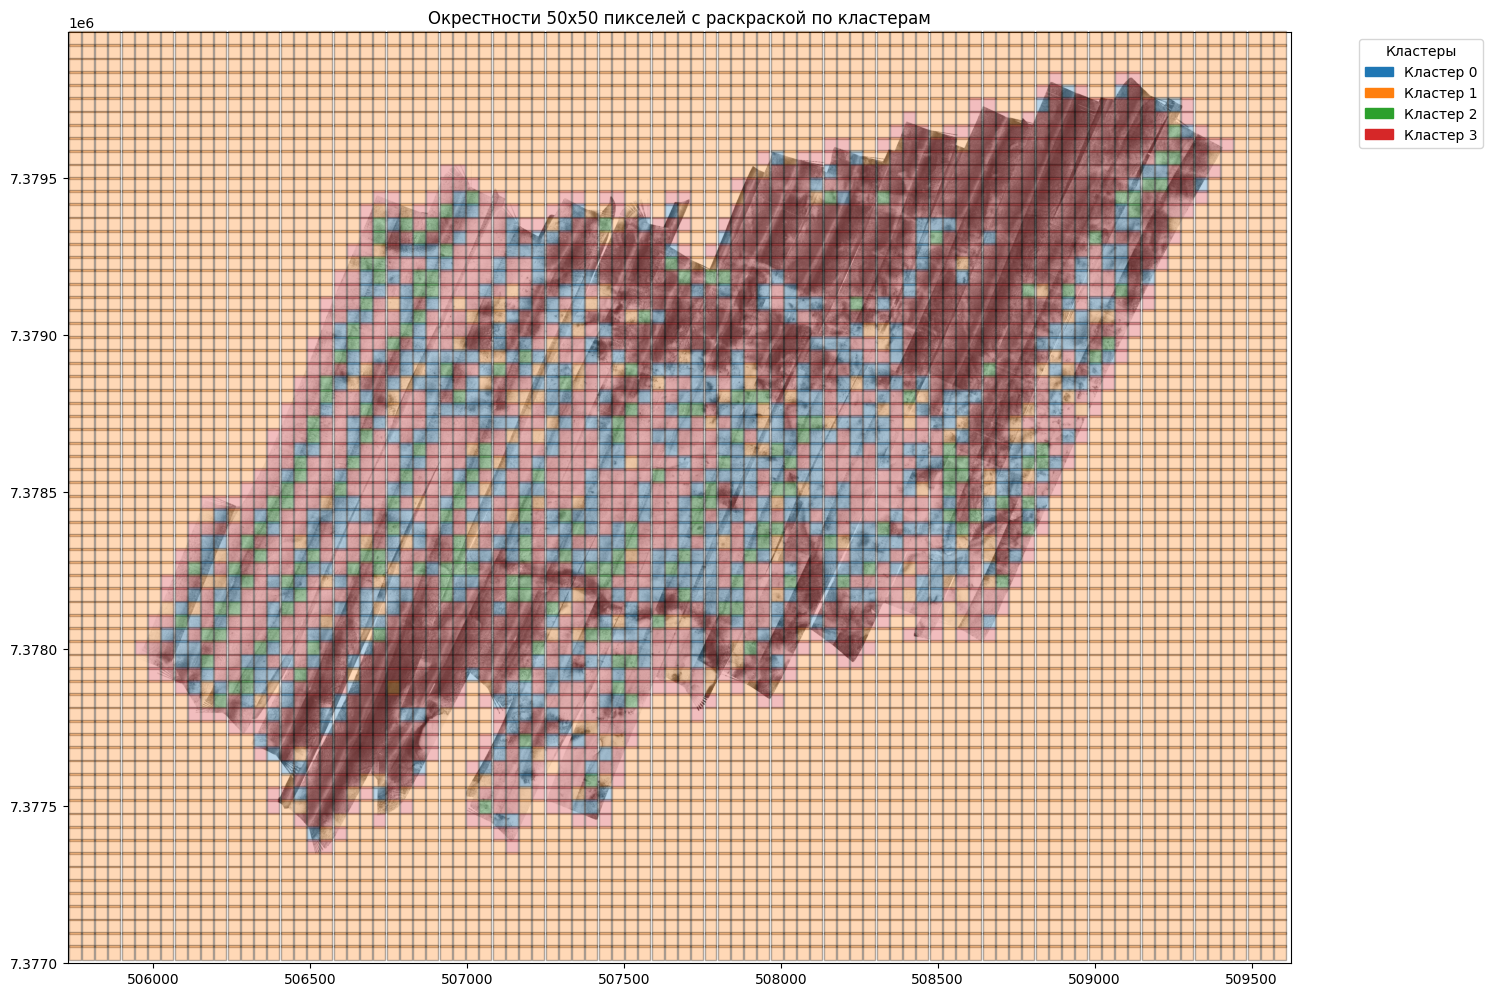

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Загрузка данных с кластерами
filtered_df = pd.read_excel('filtered_dataset_with_clusters.xlsx')

# Создаем цветовую схему для кластеров
cluster_colors = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728'
}

# Размер окрестности
window_size = 50
half_window = window_size // 2

with rasterio.open("/content/drive/MyDrive/gazprom_data/00_SideScanSonar.tif") as src:
    fig, ax = plt.subplots(figsize=(15, 15))

    # Отображение растрового изображения
    show(src, ax=ax, cmap='gray')

    # Для создания легенды
    legend_patches = []

    for idx, row in filtered_df.iterrows():
        x, y = row['x'], row['y']
        cluster = row['Cluster']  # Убедитесь, что имя столбца с кластерами правильное

        # Получаем цвет для текущего кластера
        color = cluster_colors.get(cluster, 'gray')  # Серый для неопознанных кластеров

        px, py = rasterio.transform.rowcol(src.transform, x, y)

        if (px - half_window >= 0 and px + half_window < src.height and
            py - half_window >= 0 and py + half_window < src.width):

            # Координаты углов
            x_min = py - half_window
            x_max = py + half_window + 1
            y_min = px - half_window
            y_max = px + half_window + 1

            left_bottom = src.transform * (x_min, y_min)
            right_top = src.transform * (x_max, y_max)

            # Создание прямоугольника
            rect = Rectangle(
                (left_bottom[0], left_bottom[1]),
                right_top[0] - left_bottom[0],
                right_top[1] - left_bottom[1],
                linewidth=0,
                edgecolor=None,
                facecolor='none'
            )

            ax.add_patch(rect)
            ax.text(x, y, ' ', color='white', fontsize=2,
                   ha='center', va='center', bbox=dict(facecolor=color, alpha=0.3))

        else:
            print(f"Точка {idx} пропущена: выходит за границы изображения")

    # Создаем легенду
    for cluster, color in cluster_colors.items():
        legend_patches.append(mpatches.Patch(color=color, label=f'Кластер {cluster}'))

    ax.legend(handles=legend_patches, title='Кластеры', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f"Окрестности {window_size}x{window_size} пикселей с раскраской по кластерам")
plt.tight_layout()
plt.show()

# Тепловые карты

<ipython-input-109-48ffd66d7d3f>:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


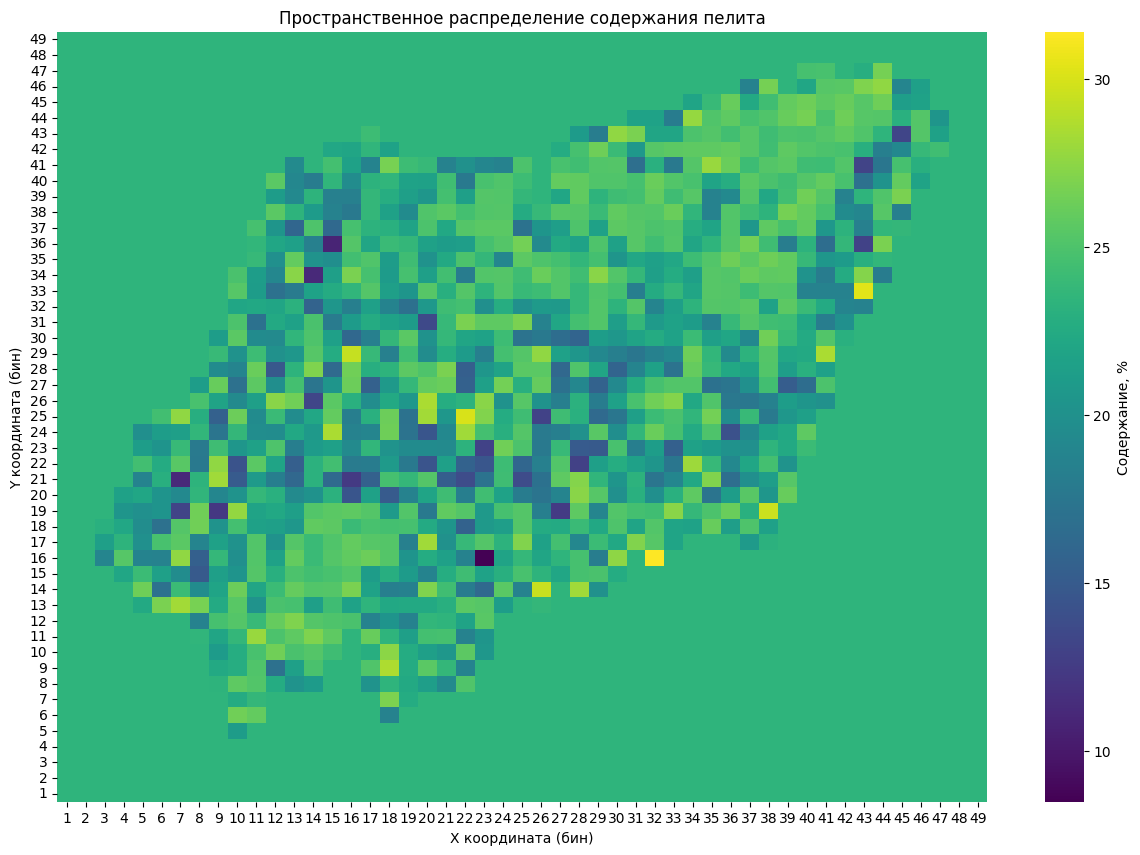

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Создаем координатную сетку
x_bins = np.linspace(filtered_df['x'].min(), filtered_df['x'].max(), 50)
y_bins = np.linspace(filtered_df['y'].min(), filtered_df['y'].max(), 50)

# Группируем данные по пространственным ячейкам
heat_data = filtered_df.copy()
heat_data['x_bin'] = pd.cut(heat_data['x'], bins=x_bins, labels=np.arange(1, len(x_bins)))
heat_data['y_bin'] = pd.cut(heat_data['y'], bins=y_bins, labels=np.arange(1, len(y_bins)))

pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='Пелит <1-5 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания пелита")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-110-496134146b5f>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


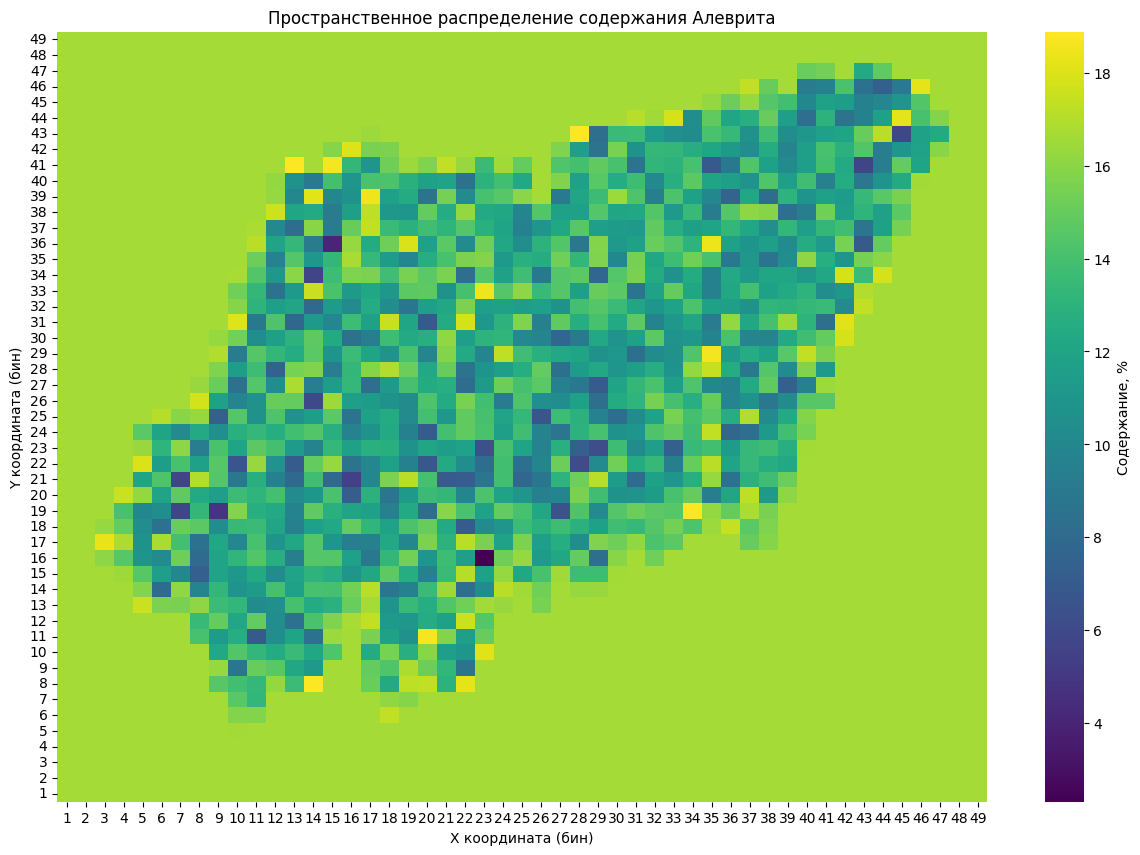

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='Алеврит 5-10 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания Алеврита")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-111-c5124ffb9830>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


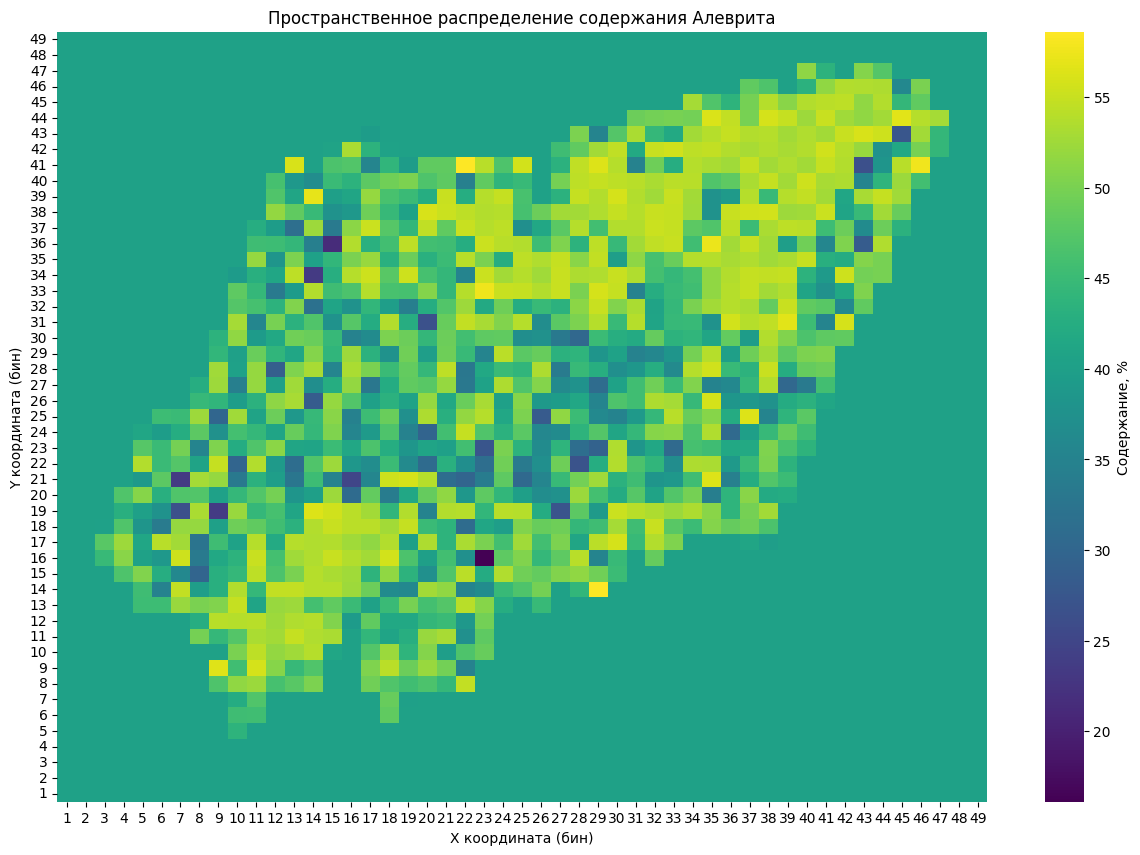

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='Алеврит 10-50 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания Алеврита")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-112-01359e19bd53>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


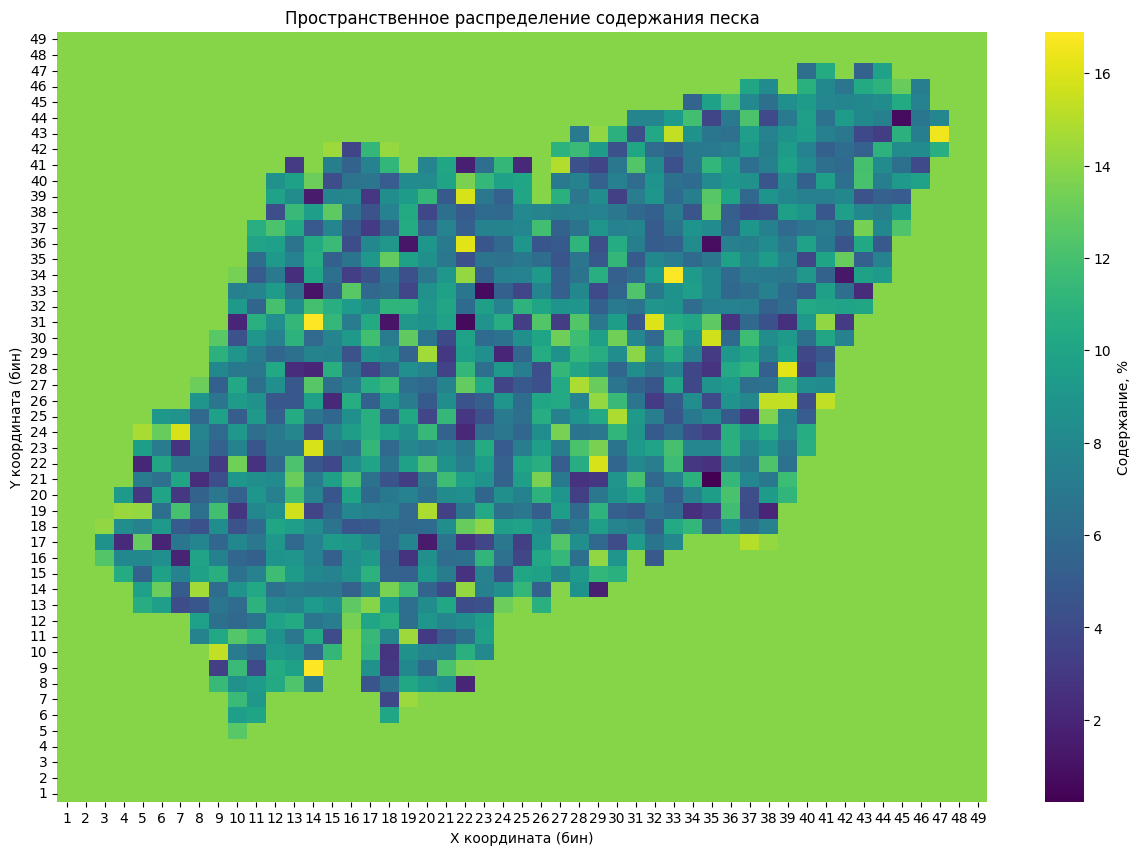

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='т-з песок 50-100 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания песка")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-113-1d514c80ea08>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


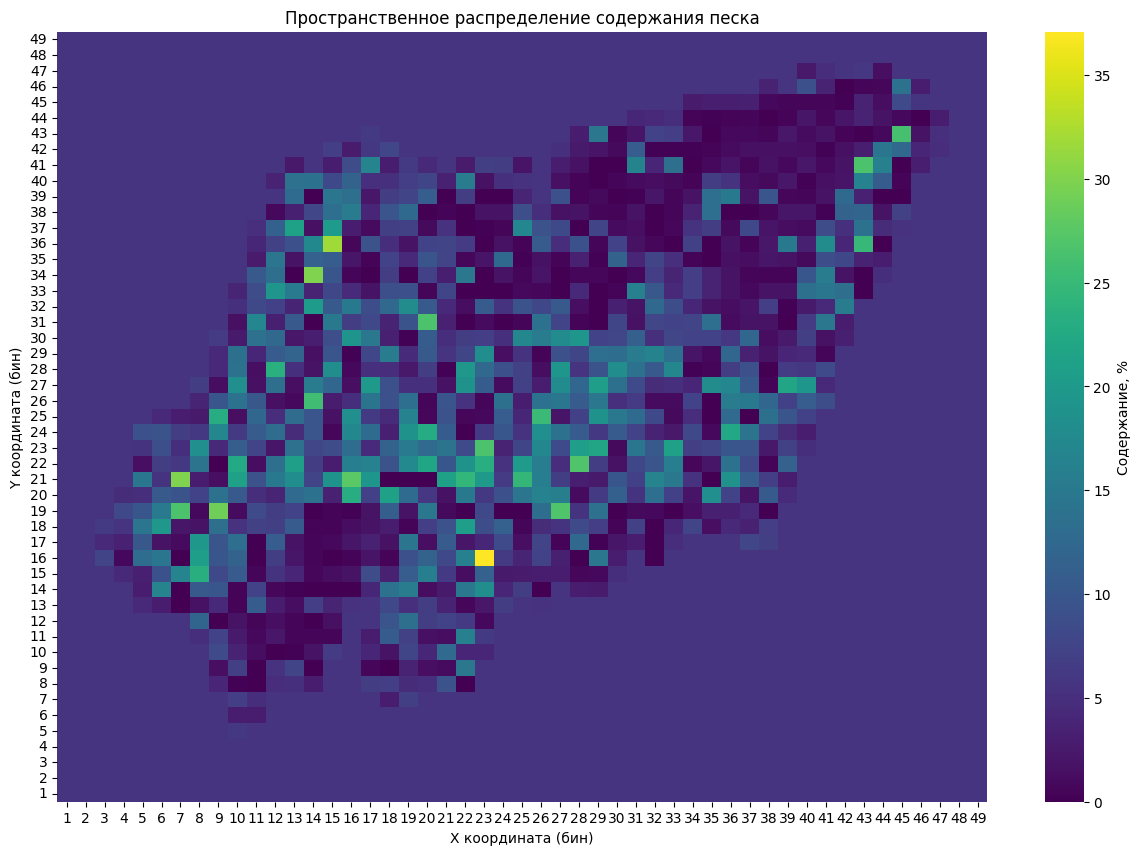

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='м-з песок 100-250 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания песка")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-114-230f0da72b43>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


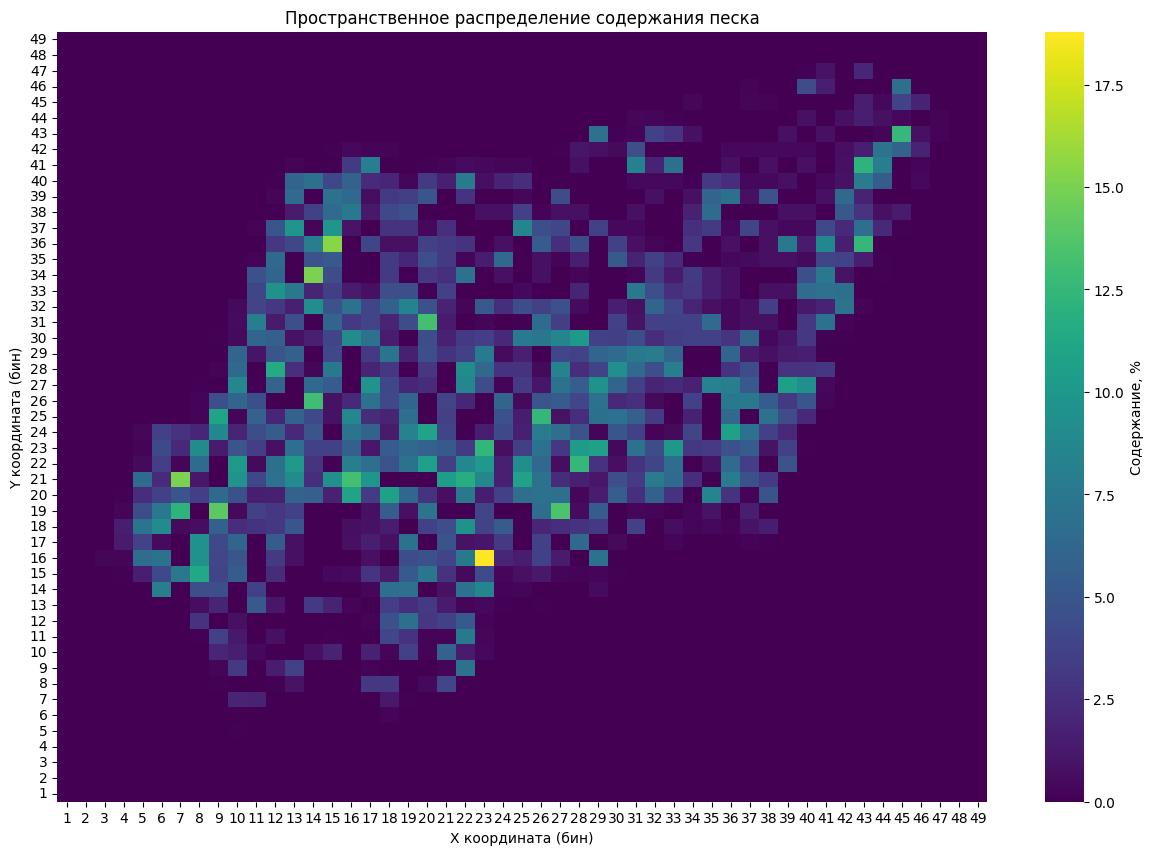

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='с-з песок 250-500 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания песка")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()

<ipython-input-115-2bd5b031d0e3>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = heat_data.pivot_table(


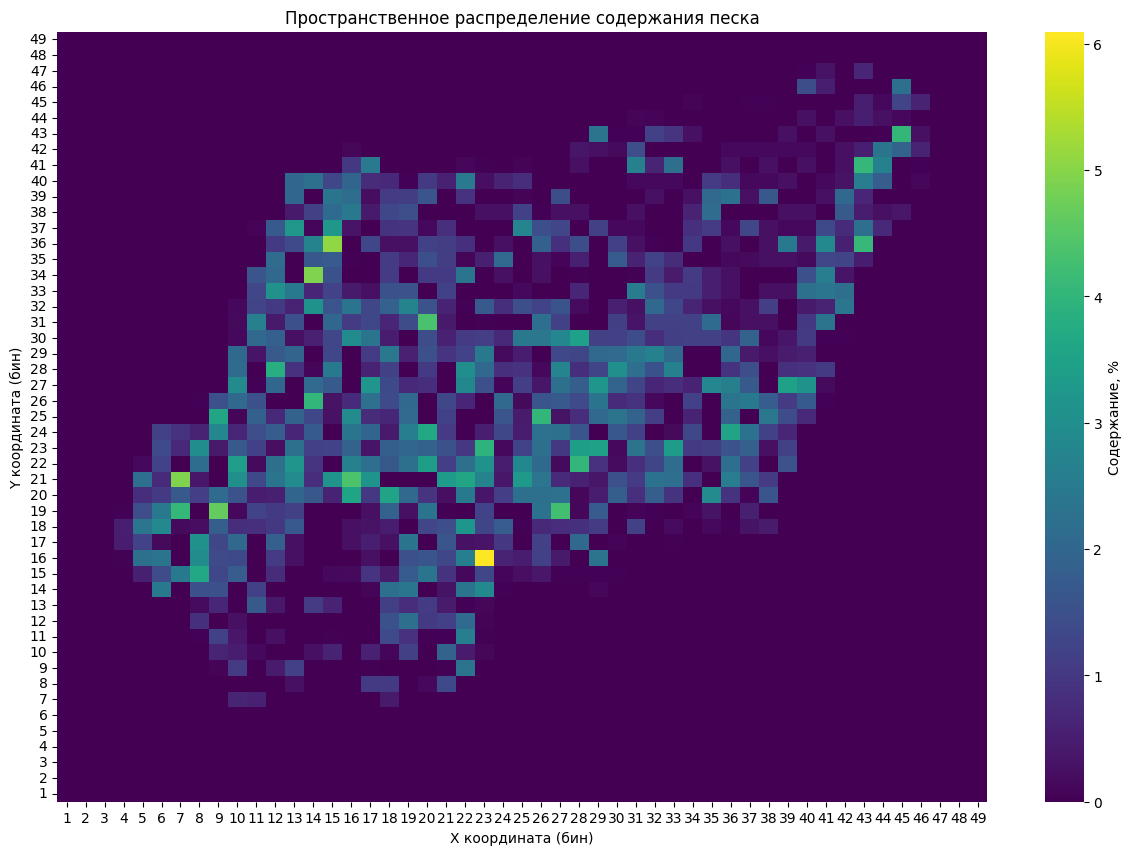

In [ ]:
pivot_table = heat_data.pivot_table(
    index='y_bin',
    columns='x_bin',
    values='к-з песок 500-1000 мкм, %',
    aggfunc='mean'
)

# Визуализация
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    pivot_table,
    cmap='viridis',
    cbar_kws={'label': 'Содержание, %'}
)

# Настройка осей
ax.invert_yaxis()
plt.title("Пространственное распределение содержания песка")
plt.xlabel("X координата (бин)")
plt.ylabel("Y координата (бин)")

plt.show()